In [4]:
import os
import zipfile
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from zipfile import ZipFile
import albumentations as A

import cv2
import numpy as np
from clearml import Task
from dotenv import load_dotenv
from mglyph_ml.experiment.e1.util import load_image_into_ndarray
from IPython.display import Image, display

from mglyph_ml.dataset.glyph_dataset import GlyphDataset
from mglyph_ml.dataset.manifest import DatasetManifest, ManifestSample
from mglyph_ml.experiment.e1.experiment import ExperimentConfig
from mglyph_ml.experiment.e1.train_model import train_and_test_model

In [5]:
path = Path("../data/uni.mglyph")

config = ExperimentConfig(
    task_name="Experiment 1.2.1",
    task_tag="exp-1.2.1",
    dataset_path="../data/uni.mglyph",
    gap_start_x=40.0,
    gap_end_x=60.0,
    quick=True,
    seed=420,
    max_iterations=5,
    offline=True,
)

Task.set_offline(config.offline)
task: Task = Task.init(project_name="mglyph-ml", task_name=config.task_name)
task.add_tags(config.task_tag)
task.connect(config)

load_dotenv()

True

In [ ]:
# loading everything... this cell takes the longest time
temp_archive = zipfile.ZipFile(path, "r")

manifest_data = temp_archive.read("manifest.json")
manifest = DatasetManifest.model_validate_json(manifest_data)

samples_all = manifest.samples["uni"]

# Create index mappings for each subset
train_indices = [i for i, sample in enumerate(samples_all) if sample.x < 40.0 or sample.x >= 60]
gap_indices = [i for i, sample in enumerate(samples_all) if sample.x >= 40.0 and sample.x < 60]
test_indices = list(range(len(samples_all)))

# Load all images once
with ThreadPoolExecutor(max_workers=64) as executor:
    images_all = list(
        executor.map(lambda sample: load_image_into_ndarray(temp_archive, sample.filename), samples_all)
    )

# Reference image subsets using indices
images_train = [images_all[i] for i in train_indices]
images_gap = [images_all[i] for i in gap_indices]
images_test = images_all

labels_train = [samples_all[i].x for i in train_indices]
labels_gap = [samples_all[i].x for i in gap_indices]
labels_test = [sample.x for sample in samples_all]

temp_archive.close()

Number of images: 12039
First image type: <class 'numpy.ndarray'>
First image dtype: uint8
First image shape: (512, 512, 3)
First image is ndarray: True
First image in RGB format: True


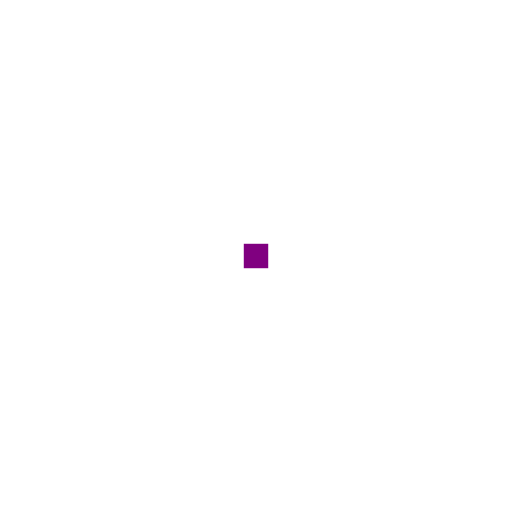

In [7]:
# Verify RGB format and display sample image
print(f"Number of images: {len(images_train)}")
print(f"First image type: {type(images_train[0])}")
print(f"First image dtype: {images_train[0].dtype}")
print(f"First image shape: {images_train[0].shape}")
print(f"First image is ndarray: {isinstance(images_train[0], np.ndarray)}")
print(f"First image in RGB format: {images_train[0].dtype == np.uint8 and len(images_train[0].shape) == 3}")

# Display one sample image (convert BGR to RGB for display)
display(Image(data=cv2.imencode('.png', images_train[0])[1].tobytes()))

(512, 512, 3)


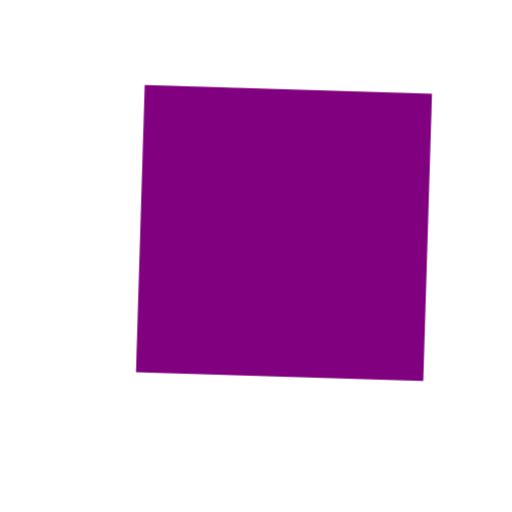

In [ ]:
import torch
from albumentations.pytorch import ToTensorV2

affine = A.Affine(
    rotate=(-5, 5),
    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    fit_output=False,
    keep_ratio=True,
    border_mode=cv2.BORDER_CONSTANT,
    fill=255,
    p=1.0,
)
normalize = A.Normalize(normalization="min_max")
to_tensor = ToTensorV2()
pipeline = A.Compose([affine, normalize, to_tensor], seed=420)
normalize_pipeline = A.Compose([normalize, to_tensor])

def affine_and_normalize(image: np.ndarray) -> torch.Tensor:
    return pipeline(image=image)["image"]

def just_normalize(image: np.ndarray) -> torch.Tensor:
    return normalize_pipeline(image=image)["image"]

dataset_train = GlyphDataset(images=images_train, labels=labels_train, transform=affine_and_normalize)
dataset_gap = GlyphDataset(images=images_gap, labels=labels_gap, transform=just_normalize)
dataset_test = GlyphDataset(images=images_test, labels=labels_test, transform=just_normalize)

image = dataset_train[2000][0].numpy().transpose(1, 2, 0) * 255.0
print(image.shape)
display(Image(data=cv2.imencode(".png", image)[1].tobytes()))

In [ ]:
device = os.environ["MGML_DEVICE"]

train_and_test_model(
    device=device,
    dataset_train=dataset_train,
    dataset_gap=dataset_gap,
    dataset_test=dataset_test,
    seed=420,
    data_loader_num_workers=32,
    batch_size=256,
    quick=False,
    max_epochs=20,
    model_save_path=Path("../models/exp1.pt"),
)